<a href="https://colab.research.google.com/github/littlekii/DPBBP/blob/main/bbp_hetero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip install GPy
import GPy
import pandas as pd
import zipfile
import urllib.request
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from sklearn.model_selection import KFold

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from google.colab import files
%config InlineBackend.figure_format = 'svg'

ERROR: torch-0.4.1-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.
     |████████████████████████████████| 962kB 3.1MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2564971 sha256=499ac6364f3de9ba3b3174c993a104e375ecf6b98279364680123bfff5b5fd80
  Stored in directory: /root/.cache/pip/wheels/23/99/8d/d0c3dee7db4af58190cde6abdb45e6a7ded2f9f01ff528dd0f
  Created wheel for paramz: filename=paramz-0.9.5-cp37-none-any.whl size=102566 sha256=f5b9c008b46923890feed74eb9aaef6e8adb9167ba013b741982539e631f506c
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy paramz


In [ ]:
torch.cuda.device(0)
torch.cuda.get_device_name(torch.cuda.current_device())

'Tesla P100-PCIE-16GB'

In [ ]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

In [ ]:
def log_gaussian_loss(output, target, sigma, no_dim, sum_reduce=True):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma) - 0.5*no_dim*np.log(2*np.pi)
    
    if sum_reduce:
        return -(log_coeff + exponent).sum()
    else:
        return -(log_coeff + exponent)


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

In [ ]:
class BayesLinear_Normalq(nn.Module):
    def __init__(self, input_dim, output_dim, prior):
        super(BayesLinear_Normalq, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior = prior
        
        scale = (2/self.input_dim)**0.5
        rho_init = np.log(np.exp((2/self.input_dim)**0.5) - 1)
        self.weight_mus = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.01, 0.01))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-3, -3))
        
        self.bias_mus = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.01, 0.01))
        self.bias_rhos = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-4, -3))
        
    def forward(self, x, sample = True):
        
        if sample:
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            bias_epsilons =  Variable(self.bias_mus.data.new(self.bias_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            bias_stds = torch.log(1 + torch.exp(self.bias_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            bias_sample = self.bias_mus + bias_epsilons*bias_stds
            
            output = torch.mm(x, weight_sample) + bias_sample
            
            # computing the KL loss term
            prior_cov, varpost_cov = self.prior.sigma**2, weight_stds**2
            KL_loss = 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*weight_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.weight_mus - self.prior.mu)**2/prior_cov).sum()
            
            prior_cov, varpost_cov = self.prior.sigma**2, bias_stds**2
            KL_loss = KL_loss + 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*bias_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.bias_mus - self.prior.mu)**2/prior_cov).sum()
            
            return output, KL_loss
        
        else:
            output = torch.mm(x, self.weight_mus) + self.bias_mus
            return output, KL_loss
        
    def sample_layer(self, no_samples):
        all_samples = []
        for i in range(no_samples):
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            
            all_samples += weight_sample.view(-1).cpu().data.numpy().tolist()
            
        return all_samples

In [ ]:
class BBP_Heteroscedastic_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units):
        super(BBP_Heteroscedastic_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        self.layer1 = BayesLinear_Normalq(input_dim, num_units, gaussian(0, 1))
        self.layer2 = BayesLinear_Normalq(num_units, 2*output_dim, gaussian(0, 1))
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
    
    def forward(self, x):
        
        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, KL_loss = self.layer1(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        
        return x, KL_loss_total

In [ ]:
class BBP_Heteroscedastic_Model_Wrapper:
    def __init__(self, network, learn_rate, batch_size, no_batches):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = network
        self.network.cuda()
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.learn_rate)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)

            # calculate fit loss based on mean and standard deviation of output
            fit_loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
            fit_loss_total = fit_loss_total + fit_loss
        
        KL_loss_total = KL_loss_total/self.no_batches
        total_loss = (fit_loss_total + KL_loss_total)/(no_samples*x.shape[0])
        total_loss.backward()
        self.optimizer.step()

        return fit_loss_total/no_samples, KL_loss_total,output[:, :1]
    
    def get_loss_and_rmse(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        means, stds = [], []
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)
            means.append(output[:, :1, None])
            stds.append(output[:, 1:, None].exp())
            
        means, stds = torch.cat(means, 2), torch.cat(stds, 2)
        mean = means.mean(dim=2)
        std = (means.var(dim=2) + stds.mean(dim=2)**2)**0.5
            
        # calculate fit loss based on mean and standard deviation of output
        logliks = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1, sum_reduce=False)
        rmse = float((((mean - y)**2).mean()**0.5).cpu().data)

        return logliks, rmse

Epoch:     1/  200, Fit loss = 357.060, KL loss = 2124.315
Epoch:   101/  200, Fit loss = 219.335, KL loss = 1671.343
Epoch:   200/  200, Fit loss = 211.892, KL loss = 1470.302


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

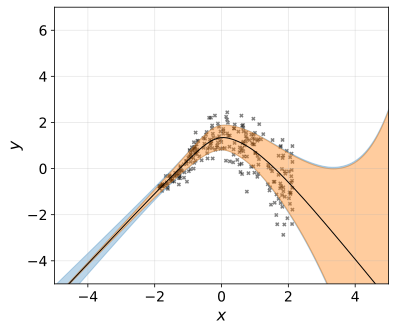

Epoch:     1/  200, Fit loss = 356.017, KL loss = 2115.075
Epoch:   101/  200, Fit loss = 254.416, KL loss = 1679.914
Epoch:   200/  200, Fit loss = 230.534, KL loss = 1508.619
Epoch:     1/  200, Fit loss = 353.304, KL loss = 2117.570
Epoch:   101/  200, Fit loss = 193.848, KL loss = 1771.288
Epoch:   200/  200, Fit loss = 183.114, KL loss = 1644.999
Epoch:     1/  200, Fit loss = 356.370, KL loss = 2125.937
Epoch:   101/  200, Fit loss = 248.757, KL loss = 1683.858
Epoch:   200/  200, Fit loss = 252.151, KL loss = 1464.257
Epoch:     1/  200, Fit loss = 356.107, KL loss = 2136.058
Epoch:   101/  200, Fit loss = 189.601, KL loss = 1824.726
Epoch:   200/  200, Fit loss = 193.654, KL loss = 1664.710
Epoch:     1/  200, Fit loss = 354.667, KL loss = 2124.703
Epoch:   101/  200, Fit loss = 192.041, KL loss = 1716.543
Epoch:   200/  200, Fit loss = 191.373, KL loss = 1514.154
Epoch:     1/  200, Fit loss = 356.503, KL loss = 2131.665
Epoch:   101/  200, Fit loss = 208.554, KL loss = 1665.3

In [ ]:
np.random.seed(5)
average_mse = []
for iter in range(10):
  no_points = 400
  lengthscale = 1
  variance = 1.0
  sig_noise = 0.3
  x = np.random.uniform(-3, 3, no_points)[:, None]
  x.sort(axis = 0)

  k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
  C = k.K(x, x) + np.eye(no_points)*(x + 2)**2*sig_noise**2

  y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
  y = (y - y.mean())
  x_train = x[75:325]
  y_mean = y[75:325].mean()
  y_std = y[75:325].var()**0.5
  y_train = (y[75:325] - y_mean)/y_std


  num_epochs, batch_size, nb_train = 200, len(x_train), len(x_train)

  net = BBP_Heteroscedastic_Model_Wrapper(network=BBP_Heteroscedastic_Model(input_dim=1, output_dim=1, num_units=200),
                                          learn_rate=1e-2, batch_size=batch_size, no_batches=1)

  fit_loss_train = np.zeros(num_epochs)
  KL_loss_train = np.zeros(num_epochs)
  total_loss = np.zeros(num_epochs)

  best_net, best_loss = None, float('inf')
  
  for i in range(num_epochs):
      
      fit_loss, KL_loss, y_hat = net.fit(x_train, y_train, no_samples = 10)
      fit_loss_train[i] += fit_loss.cpu().data.numpy()
      KL_loss_train[i] += KL_loss.cpu().data.numpy()
      
      total_loss[i] = fit_loss_train[i] + KL_loss_train[i]
      if fit_loss < best_loss:
          best_loss = fit_loss
          best_net = copy.deepcopy(net.network)
          
      if i % 100 == 0 or i == num_epochs - 1:
          
          print("Epoch: %5d/%5d, Fit loss = %7.3f, KL loss = %8.3f" %
                (i + 1, num_epochs, fit_loss_train[i], KL_loss_train[i]))

          samples = []
          for i in range(100):
              preds = net.network.forward(torch.linspace(-3, 3, 200).cuda())[0]
              samples.append(preds.cpu().data.numpy()[:, 0])
  average_mse.append(np.power((y_hat.cpu().data.numpy()-y_train),2).mean())
  if iter==0:
    samples, noises = [], []
    for i in range(100):
        preds = best_net.forward(torch.linspace(-5, 5, 200).cuda())[0]
        samples.append(preds[:, 0].cpu().data.numpy()* y_std + y_mean)
        noises.append(preds[:, 1].exp().cpu().data.numpy()* y_std)

    samples = np.array(samples)
    noises = np.array(noises)
    means = samples.mean(axis = 0)

    aleatoric = (noises**2).mean(axis = 0)**0.5
    epistemic = samples.var(axis = 0)**0.5
    aleatoric = np.minimum(aleatoric, 10e3)
    epistemic = np.minimum(epistemic, 10e3)

    total_unc = (aleatoric**2 + epistemic**2)**0.5

    c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    x_mean, x_std = x_train.mean(), x_train.var()**0.5
    plt.figure(figsize = (6, 5))
    plt.style.use('default')
    plt.scatter(x_train * x_std + x_mean, y_train * y_std + y_mean, s = 10, marker = 'x', color = 'black', alpha = 0.5)
    plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
    plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
    plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = 'Aleatoric')
    plt.plot(np.linspace(-5, 5, 200)* x_std + x_mean, means, color = 'black', linewidth = 1)
    plt.xlim([-5, 5])
    plt.ylim([-5, 7])
    plt.xlabel('$x$', fontsize=16)
    plt.ylabel('$y$', fontsize=16)
    plt.tick_params(labelsize=30)
    plt.xticks(np.arange(-4, 5, 2),fontsize=14)
    plt.yticks(np.arange(-4, 7, 2),fontsize=14)
    #plt.gca().set_yticklabels([])
    plt.gca().yaxis.grid(alpha=0.3)
    plt.gca().xaxis.grid(alpha=0.3)
    plt.savefig('bbp_hetero.pdf', bbox_inches = 'tight')

    files.download("bbp_hetero.pdf")

    plt.show()
print(average_mse,np.median(average_mse))

In [ ]:
!pip install opacus
from opacus import PrivacyEngine

     |████████████████████████████████| 122kB 3.6MB/s 


In [ ]:
class BBP_Heteroscedastic_Model_Wrapper:
    def __init__(self, network, learn_rate, batch_size, no_batches):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = network
        self.network.cuda()
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.learn_rate)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)

            # calculate fit loss based on mean and standard deviation of output
            fit_loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1, sum_reduce=False)
            fit_loss_total = fit_loss_total + fit_loss
        
        KL_loss_total = KL_loss_total/self.no_batches
        total_loss = (fit_loss_total + KL_loss_total)/(no_samples*x.shape[0])
        #total_loss.backward()
        #########################################################################################################
        clipped_grads = {name: torch.zeros_like(param) for name, param in self.network.named_parameters()}

        for i in range(total_loss.size(0)):
            total_loss[i].backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(self.network.parameters(),100)
            for name, param in self.network.named_parameters():
                clipped_grads[name] += param.grad / total_loss.size(0)
            self.network.zero_grad()

        for name, param in self.network.named_parameters():
            param.grad = clipped_grads[name]

        self.optimizer.step()
        with torch.no_grad():
            for param in self.network.parameters():
                param.add_(torch.randn_like(param) * 10/total_loss.size(0))
        #########################################################################################################

        return fit_loss_total/no_samples, KL_loss_total,output[:, :1]
    
    def get_loss_and_rmse(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        means, stds = [], []
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)
            means.append(output[:, :1, None])
            stds.append(output[:, 1:, None].exp())
            
        means, stds = torch.cat(means, 2), torch.cat(stds, 2)
        mean = means.mean(dim=2)
        std = (means.var(dim=2) + stds.mean(dim=2)**2)**0.5
            
        # calculate fit loss based on mean and standard deviation of output
        logliks = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1, sum_reduce=False)
        rmse = float((((mean - y)**2).mean()**0.5).cpu().data)

        return logliks, rmse

1.0056538682018756
Epoch:     1/  200, Fit loss = 353.977, KL loss = 2122.796
0.9632763111927387
0.9793022076140955
0.972210043519872
0.9884634840923079
0.9589481561587474
0.9250974969409476
0.9654060171545011
0.9378202271751087
0.8405101445655401
0.9400389824796349
0.8533222443437148
0.8449541891455898
0.8228569397995358
0.7373102507599798
0.7628111139698545
0.7869938087758658
0.7519727400115384
0.6767750524565411
1.0589921872414696
0.5963027192737599
0.8173060748083594
0.6599510311745018
0.7048825311443354
0.6331319416242671
0.6607104632874636
0.8274507291748175
0.7961932425667325
0.8170579678357639
0.556812066436024
0.6050317148517755
0.6367288496632675
0.5545883406469684
0.6164033908480493
0.5201120243121645
0.5606281139845664
0.5618308140848005
0.5155950650030685
0.5653619148773511
0.7433390630560793
0.7095877671618938
0.7541878175953739
0.5992312960234488
0.5577200434411428
0.5101283831342288
1.073763309621366
0.6641994033447616
0.7306862621002528
0.8981427121551695
0.59247093466

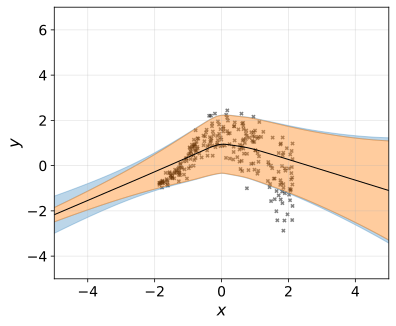

0.9905612592613102
Epoch:     1/  200, Fit loss = 355.788, KL loss = 2129.797
0.9544883405747064
0.9494099108889416
0.8355782016245064
0.8285334235370478
0.8687339786779787
0.7765679227778077
0.6849559809218001
0.7071281204461145
0.7330589155889279
0.7097407598686648
0.7947855918186044
0.7764980050460845
0.6596617476684612
0.7131422273501948
0.89445912445103
0.721387663815596
0.7848044344164122
0.7195739475347873
0.6652952100679038
0.8106605770214452
0.6386373497733976
0.6408860847463524
0.6094414592600249
0.6344010759706198
0.6485492507618358
0.5926183744271849
0.7228042662740188
0.7387284646257527
0.714001347824423
0.9357654576514157
0.6280742709607892
0.776224147692707
0.5968337412730383
0.6626926754036614
0.6511144228073049
0.682394579985158
0.7042074689189695
1.118754354154431
0.7583958596562168
0.7432678787546968
1.0516226003013465
0.8201727820754723
0.8094276332039001
1.3778952506165225
1.2806606184646017
0.9228412990273162
0.8495710341989049
0.9735018388001722
1.070138462045051

In [ ]:
np.random.seed(5)
average_mse = []
for iter in range(5):
  no_points = 400
  lengthscale = 1
  variance = 1.0
  sig_noise = 0.3
  x = np.random.uniform(-3, 3, no_points)[:, None]
  x.sort(axis = 0)

  k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
  C = k.K(x, x) + np.eye(no_points)*(x + 2)**2*sig_noise**2

  y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
  y = (y - y.mean())
  x_train = x[75:325]
  y_mean = y[75:325].mean()
  y_std = y[75:325].var()**0.5
  y_train = (y[75:325] - y_mean)/y_std


  num_epochs, batch_size, nb_train = 200, len(x_train), len(x_train)

  net = BBP_Heteroscedastic_Model_Wrapper(network=BBP_Heteroscedastic_Model(input_dim=1, output_dim=1, num_units=200),
                                          learn_rate=1e-2, batch_size=batch_size, no_batches=1)

  fit_loss_train = np.zeros(num_epochs)
  KL_loss_train = np.zeros(num_epochs)
  total_loss = np.zeros(num_epochs)

  best_net, best_loss = None, float('inf')
 
  for i in range(num_epochs):
      fit_loss, KL_loss, y_hat = net.fit(x_train, y_train, no_samples = 10)
      print(np.power((y_hat.cpu().data.numpy()-y_train),2).mean())
      average_mse.append(np.power((y_hat.cpu().data.numpy()-y_train),2).mean())
      fit_loss=fit_loss.sum()
      fit_loss_train[i] += fit_loss.cpu().data.numpy()
      KL_loss_train[i] += KL_loss.cpu().data.numpy()
      
      total_loss[i] = fit_loss_train[i] + KL_loss_train[i]
      if fit_loss < best_loss:
          best_loss = fit_loss
          best_net = copy.deepcopy(net.network)
          
      if i % 100 == 0 or i == num_epochs - 1:
          
          print("Epoch: %5d/%5d, Fit loss = %7.3f, KL loss = %8.3f" %
                (i + 1, num_epochs, fit_loss_train[i], KL_loss_train[i]))

          samples = []
          for i in range(100):
              preds = net.network.forward(torch.linspace(-3, 3, 200).cuda())[0]
              samples.append(preds.cpu().data.numpy()[:, 0])
  
  if iter==0:
    samples, noises = [], []
    for i in range(100):
        preds = best_net.forward(torch.linspace(-5, 5, 200).cuda())[0]
        samples.append(preds[:, 0].cpu().data.numpy()* y_std + y_mean)
        noises.append(preds[:, 1].exp().cpu().data.numpy()* y_std)

    samples = np.array(samples)
    noises = np.array(noises)
    means = samples.mean(axis = 0)

    aleatoric = (noises**2).mean(axis = 0)**0.5
    epistemic = samples.var(axis = 0)**0.5
    aleatoric = np.minimum(aleatoric, 10e3)
    epistemic = np.minimum(epistemic, 10e3)

    total_unc = (aleatoric**2 + epistemic**2)**0.5

    c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    x_mean, x_std = x_train.mean(), x_train.var()**0.5
    plt.figure(figsize = (6, 5))
    plt.style.use('default')
    plt.scatter(x_train * x_std + x_mean, y_train * y_std + y_mean, s = 10, marker = 'x', color = 'black', alpha = 0.5)
    plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
    plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
    plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = 'Aleatoric')
    plt.plot(np.linspace(-5, 5, 200)* x_std + x_mean, means, color = 'black', linewidth = 1)
    plt.xlim([-5, 5])
    plt.ylim([-5, 7])
    plt.xlabel('$x$', fontsize=16)
    plt.ylabel('$y$', fontsize=16)
    plt.tick_params(labelsize=30)
    plt.xticks(np.arange(-4, 5, 2),fontsize=14)
    plt.yticks(np.arange(-4, 7, 2),fontsize=14)
    #plt.gca().set_yticklabels([])
    plt.gca().yaxis.grid(alpha=0.3)
    plt.gca().xaxis.grid(alpha=0.3)
    plt.savefig('dpbbp_hetero.pdf', bbox_inches = 'tight')

    #files.download("dpbbp_hetero.pdf")

    plt.show()
print(average_mse,np.median(average_mse))